In [1]:
# %pip install seaborn matplotlib scikit-learn --break-system-packages
# %pip install tqdm ipywidgets notebook

In [2]:
import os
import sys
import json
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
try:
    from IPython.display import display
except:
    pass

# Add src to path
sys.path.append(os.path.abspath("src"))

from src.client import AzureLLMClient
from src.config import EvalConfig
from src.utils import encode_image

# Load environment variables
load_dotenv()

# Configuration
CONFIG_PATH = "config/eval.yaml"
DATA_PATH = "data/annotations_balanced.csv" # Or annotations.csv
PROMPTS_DIR = "prompts/"

# Load config
config = EvalConfig(CONFIG_PATH)

print("Imports complete and config loaded.")

Imports complete and config loaded.


## 2. Load and Sample Data
We select exactly 24 images, ensuring 2 images for each of the 12 hair types (1A-4C).

In [3]:
def get_balanced_subset(csv_path, samples_per_class=2):
    df = pd.read_csv(csv_path)
    # Ensure allowed types only
    allowed_types = [f"{n}{l}" for n in "1234" for l in "ABC"]
    df = df[df['type'].isin(allowed_types)]
    
    # Sample
    subset = df.groupby('type', group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))
    
    # Verify count
    print(f"Selected {len(subset)} images.")
    print(subset['type'].value_counts())
    return subset

test_df = get_balanced_subset(DATA_PATH, samples_per_class=2)
# Display first few rows
test_df.head()

Selected 24 images.
type
1A    2
1B    2
1C    2
2A    2
2B    2
2C    2
3A    2
3B    2
3C    2
4A    2
4B    2
4C    2
Name: count, dtype: int64


/tmp/ipykernel_45783/467219597.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset = df.groupby('type', group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))


,image_path,type
0,data/Straight_1a_11.jpg,1A
17,data/Straight_1a_6.jpg,1A
20,data/Straight_1B_19.jpg,1B
37,data/Straight_1b_5.jpg,1B
40,data/Straight_1C_11.jpg,1C


## 3. Initialize Client and Classifier
We allow for a custom "Top-2" capable classifier. Note that standard prompts might only return one class, in which case Top-2 Accuracy = Top-1 Accuracy.
To enable true Top-2 measurement, your prompt should request a JSON output with a `candidates` list, e.g., `{"hair_type": "4C", "candidates": ["4C", "4B"]}`.

In [4]:
class AdvancedHairClassifier:
    def __init__(self, client, config, prompt_text):
        self.client = client
        self.cfg = config  # Use EvalConfig object
        self.prompt = prompt_text
        # Use allowed types from config or fallback
        self.allowed = set(config.evaluation.get("allowed_types", [f"{n}{l}" for n in "1234" for l in "ABC"]))

    def predict(self, image_b64):
        # Using settings from config object (EvalConfig.api is a dict)
        api_cfg = self.cfg.api
        
        exceptions = []
        for attempt in range(api_cfg.get('retries', 2) + 1):
            try:
                raw_response = self.client.classify(
                    model=api_cfg['model'],
                    system_prompt=self.prompt,
                    image_b64=image_b64,
                    temperature=api_cfg['temperature'],
                    timeout=api_cfg['timeout']
                )
                
                # Parse JSON
                try:
                    data = json.loads(raw_response)
                    primary = data.get("hair_type", "Unknown")
                    
                    # Try to find candidates list for Top-2
                    # Expecting format: {"candidates": ["1A", "1B"]} or similar
                    candidates = data.get("candidates", [])
                    if not candidates:
                        # Fallback: if only hair_type is present, candidates is just [primary]
                        candidates = [primary]
                    
                    # Ensure primary is in candidates if not present
                    if primary not in candidates:
                        candidates.insert(0, primary)
                        
                    return {
                        "primary": primary if primary in self.allowed else "Unknown",
                        "candidates": [c for c in candidates if c in self.allowed],
                        "raw": raw_response
                    }
                except json.JSONDecodeError:
                    return {"primary": "Unknown", "candidates": [], "raw": raw_response}
                    
            except Exception as e:
                exceptions.append(str(e))
                if attempt < api_cfg.get('retries', 2):
                    time.sleep(1)
        
        return {"primary": "Unknown", "candidates": [], "error": str(exceptions)}


# Initialize Client
api_key = os.getenv("AZUREOPENAI_API_KEY")
# key name fixed based on .env content
endpoint = os.getenv("AZUREOPENAI_API_ENDPOINT") 
api_version = os.getenv("AZUREOPENAI_API_VERSION", "2024-02-15-preview")

if not api_key:
    print("WARNING: AZUREOPENAI_API_KEY not found in environment. Check your .env file.")
if not endpoint:
    print("WARNING: AZUREOPENAI_API_ENDPOINT not found in environment. Check your .env file.")

# If endpoint is None, AzureOpenAI might fail or use default if configured elsewhere.
client = AzureLLMClient(api_key, endpoint, api_version)
print("Client initialized.")

Client initialized.


## 4. Run Evaluation on All Prompts
This loop iterates through all `.txt` files in the `prompts/` directory.

In [6]:
# Define neighbor groups based on visual similarity (from run.ipynb)
NEIGHBORS = {
    "1A": ["1A", "1B"],
    "1B": ["1A", "1B", "1C"], 
    "1C": ["1B", "1C", "2A"],
    "2A": ["1C", "2A", "2B"],
    "2B": ["2A", "2B", "2C"],
    "2C": ["2B", "2C", "3A"],
    "3A": ["2C", "3A", "3B"],
    "3B": ["3A", "3B", "3C"],
    "3C": ["3B", "3C", "4A"],
    "4A": ["3C", "4A", "4B"],
    "4B": ["4A", "4B", "4C"],
    "4C": ["4B", "4C"]
}

# Provide a helper function to calculate Top-K and Neighbor accuracy
def calculate_metrics(results_df):
    total = len(results_df)
    if total == 0:
        return {}
    
    # Top-1: Primary prediction matches true type
    top1_correct = sum(results_df['type'] == results_df['pred_primary'])
    
    # Neighbor Accuracy: True type is in the neighbor list of the predicted type
    def check_neighbor(row):
        pred = row['pred_primary']
        true_val = row['type']
        # Check if true label is in the neighbors of the predicted label
        if pred in NEIGHBORS:
            return true_val in NEIGHBORS[pred]
        return pred == true_val # Fallback to exact match if pred not in map

    neighbor_correct = results_df.apply(check_neighbor, axis=1).sum()
    
    # Top-2 (Standard): True type is in top 2 candidates
    def check_top2(row):
        cands = row['pred_candidates']
        top2 = cands[:2]
        return row['type'] in top2

    top2_correct = results_df.apply(check_top2, axis=1).sum()
    
    return {
        "Accuracy (Top-1)": top1_correct / total,
        "Accuracy (Neighbor)": neighbor_correct / total,
        # "Accuracy (Top-2)": top2_correct / total, # Keeping generic Top-2 if needed, but per request focusing on neighbors
        "Avg Latency (s)": results_df['latency'].mean(),
        "Median Latency (s)": results_df['latency'].median(),
        "P95 Latency (s)": results_df['latency'].quantile(0.95)
    }

prompt_files = glob.glob(os.path.join(PROMPTS_DIR, "*.txt"))
prompt_files.sort()

all_results = {} # Store df per prompt
prompt_metrics = []

for p_file in prompt_files:
    p_name = os.path.basename(p_file)
    print(f"Testing Prompt: {p_name}")
    
    with open(p_file, 'r') as f:
        prompt_text = f.read()
        
    classifier = AdvancedHairClassifier(client, config, prompt_text)
    
    results = []
    
    # Using tqdm for progress bar
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc=p_name):
        img_path = row['image_path']
        true_type = row['type']
        
        # Read image
        try:
            b64_img = encode_image(img_path)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue
            
        start_t = time.time()
        pred_res = classifier.predict(b64_img)
        lat = time.time() - start_t
        
        results.append({
            "image_path": img_path,
            "type": true_type,
            "pred_primary": pred_res["primary"],
            "pred_candidates": pred_res["candidates"],
            "latency": lat,
            "raw_output": pred_res.get("raw", "")
        })
        
    res_df = pd.DataFrame(results)
    all_results[p_name] = res_df
    
    metrics = calculate_metrics(res_df)
    metrics["Prompt"] = p_name
    prompt_metrics.append(metrics)
    
    print(f"  Top-1: {metrics['Accuracy (Top-1)']:.2%}")
    print(f"  Neighbor Acc: {metrics['Accuracy (Neighbor)']:.2%}")

metrics_df = pd.DataFrame(prompt_metrics).set_index("Prompt")
display(metrics_df)

Testing Prompt: vision_only.txt


vision_only.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 25.00%
  Neighbor Acc: 95.83%
Testing Prompt: vision_only_2.txt


vision_only_2.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 29.17%
  Neighbor Acc: 83.33%
Testing Prompt: vision_only_3.txt


vision_only_3.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 0.00%
  Neighbor Acc: 0.00%
Testing Prompt: vision_only_4.txt


vision_only_4.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 0.00%
  Neighbor Acc: 0.00%
Testing Prompt: vision_only_5.txt


vision_only_5.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 0.00%
  Neighbor Acc: 0.00%
Testing Prompt: vision_only_6.txt


vision_only_6.txt:   0%|          | 0/24 [00:00<?, ?it/s]

  Top-1: 37.50%
  Neighbor Acc: 87.50%


,Accuracy (Top-1),Accuracy (Neighbor),Avg Latency (s),Median Latency (s),P95 Latency (s)
Prompt,,,,,
vision_only.txt,0.250000,0.958333,31.383989,4.040297,68.343331
vision_only_2.txt,0.291667,0.833333,32.646621,31.758237,64.141274
vision_only_3.txt,0.000000,0.000000,98.412900,105.164299,126.646988
vision_only_4.txt,0.000000,0.000000,138.172958,104.136385,128.667849
vision_only_5.txt,0.000000,0.000000,100.740393,119.851002,129.496880
vision_only_6.txt,0.375000,0.875000,31.043881,30.845677,61.334328


## 5. Visual Reports & Misclassifications
Select a specific prompt to inspect (defaulting to the one with best Top-1 accuracy).

Generating detailed report for Best Prompt: vision_only_6.txt


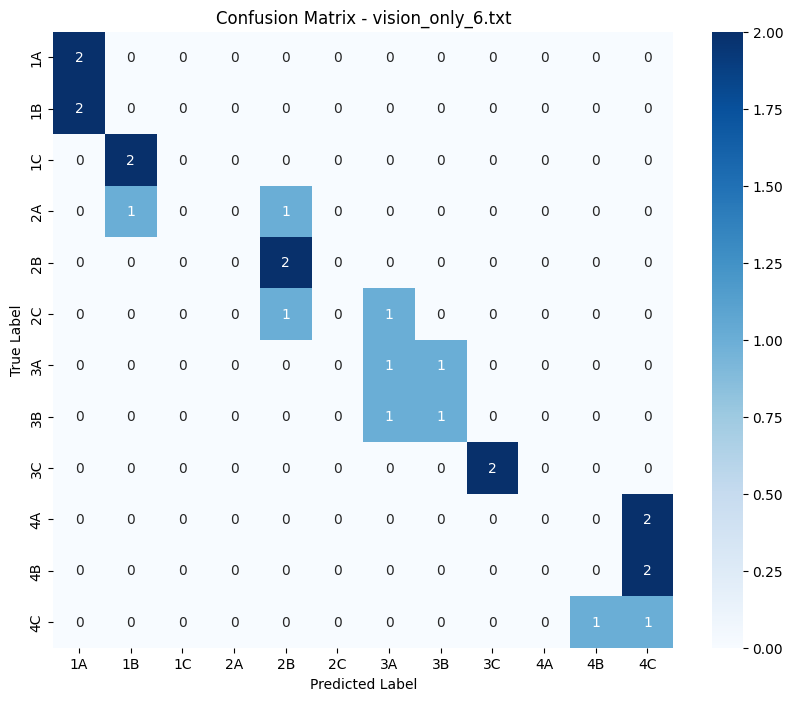

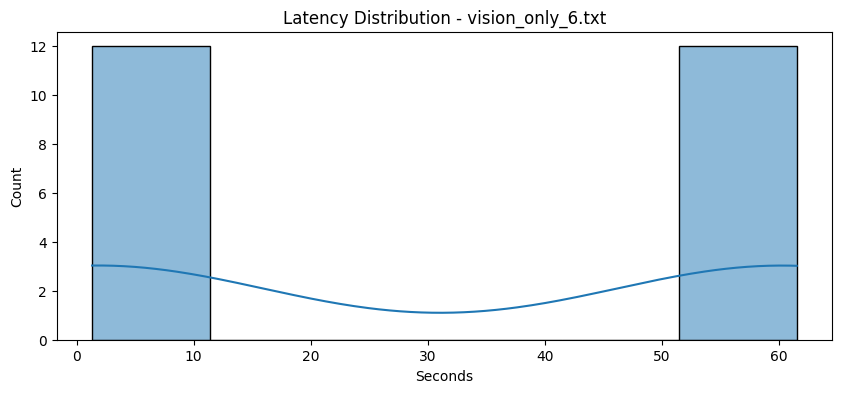

Found 15 misclassifications:


,image_path,type,pred_primary,pred_candidates,raw_output
2,data/Straight_1B_19.jpg,1B,1A,[1A],"{\n ""hair_type"": ""1A""\n}"
3,data/Straight_1b_5.jpg,1B,1A,[1A],"{\n ""hair_type"": ""1A""\n}"
4,data/Straight_1C_11.jpg,1C,1B,[1B],"{\n ""hair_type"": ""1B""\n}"
5,data/Straight_1c_4.jpg,1C,1B,[1B],"{\n ""hair_type"": ""1B""\n}"
6,data/Wavy_ 2a_2.jpg,2A,2B,[2B],"{\n ""hair_type"": ""2B""\n}"
7,data/Wavy_2a_10.jpg,2A,1B,[1B],"{\n ""hair_type"": ""1B""\n}"
10,data/Wavy_2C_2.jpg,2C,3A,[3A],"{\n ""hair_type"": ""3A""\n}"
11,data/Wavy_2C_35.jpg,2C,2B,[2B],"{\n ""hair_type"": ""2B""\n}"
13,data/Curly_3A_9.jpg,3A,3B,[3B],"{\n ""hair_type"": ""3B""\n}"
15,data/new_3B_7.jpeg,3B,3A,[3A],"{\n ""hair_type"": ""3A""\n}"


Visualizing up to 3 misclassifications:


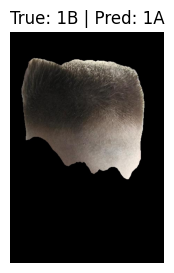

Candidates: ['1A']
--------------------------------------------------


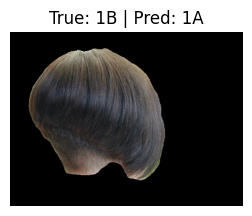

Candidates: ['1A']
--------------------------------------------------


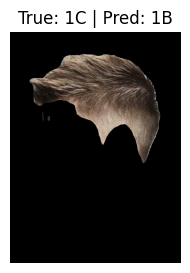

Candidates: ['1B']
--------------------------------------------------


In [7]:
if not metrics_df.empty:
    best_prompt = metrics_df['Accuracy (Top-1)'].idxmax()
    print(f"Generating detailed report for Best Prompt: {best_prompt}")
    
    df_best = all_results[best_prompt]
    
    # 1. Confusion Matrix
    y_true = df_best['type']
    y_pred = df_best['pred_primary']
    labels = sorted(list(set(y_true) | set(y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(f'Confusion Matrix - {best_prompt}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 2. Latency Histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(df_best['latency'], kde=True)
    plt.title(f'Latency Distribution - {best_prompt}')
    plt.xlabel('Seconds')
    plt.show()

    # 3. Misclassifications
    misclassed = df_best[df_best['type'] != df_best['pred_primary']]
    if not misclassed.empty:
        print(f"Found {len(misclassed)} misclassifications:")
        display(misclassed[['image_path', 'type', 'pred_primary', 'pred_candidates', 'raw_output']])
        
        # Visualize first few misclassifications
        # (Assuming we run this locally and can see images)
        print("Visualizing up to 3 misclassifications:")
        for idx, row in misclassed.head(3).iterrows():
            img_p = row['image_path']
            try:
                # If running in VS Code with local kernel, this works. 
                # If paths are correct relative to cwd
                from PIL import Image
                img = Image.open(img_p)
                plt.figure(figsize=(3, 3))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"True: {row['type']} | Pred: {row['pred_primary']}")
                plt.show()
                print(f"Candidates: {row['pred_candidates']}")
                print("-" * 50)
            except Exception as e:
                print(f"Could not load image {img_p}: {e}")

else:
    print("No results to display.")